<a href="https://colab.research.google.com/github/fcochaux/MINE-4101_Taller_4/blob/main/MINE_4101_Taller_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creación de Pipeline para la transformación, entrenamiento y predicción

__Estudiantes:__

Nicole Bahamón Martínez \
Francisco José Chaux Guzmán \
Iván Arturo Salazar

Enlace al repositorio:

In [10]:
!git clone "https://github.com/fcochaux/MINE-4101_Taller_4.git"

fatal: destination path 'MINE-4101_Taller_4' already exists and is not an empty directory.


Carga de librerías necesarias:

In [29]:
# procesamiento

import numpy as np
import pandas as pd

# visualización

import matplotlib.pyplot as plt
import seaborn as sns

# aprendizaje

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# otros

import warnings

El siguiente código impide la generación de mensajes de advertencia:

In [12]:
warnings.filterwarnings('ignore')

## 1) Revisión del conjunto de datos y de las transformaciones que serán necesarias

Lectura del conjunto de datos:

In [13]:
# lectura del conjunto de datos
df = pd.read_json('/content/MINE-4101_Taller_4/datos/DataSet_Entrenamiento_v1.json')
# convierte nombres a minúsculas
df.columns = df.columns.str.lower()
# revisa 5 casos al azar
df.sample(5)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
3463,0946-CLJTI,Male,1,Yes,No,58,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.70,5812.6,Yes
2551,5117-ZSMHQ,Female,0,Yes,Yes,71,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),89.90,6342.7,No
2411,9747-DDZOS,Female,0,No,No,1,Yes,No,Fiber optic,No,...,Yes,No,No,No,Month-to-month,No,Bank transfer (automatic),73.50,73.5,Yes
2167,0407-BDJKB,Male,0,Yes,No,60,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,95.75,5742.9,Yes
5495,0186-CAERR,Male,0,No,No,71,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),116.30,8309.55,No


Características de la base:

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        6000 non-null   object 
 1   gender            6000 non-null   object 
 2   seniorcitizen     6000 non-null   int64  
 3   partner           6000 non-null   object 
 4   dependents        6000 non-null   object 
 5   tenure            6000 non-null   int64  
 6   phoneservice      6000 non-null   object 
 7   multiplelines     6000 non-null   object 
 8   internetservice   6000 non-null   object 
 9   onlinesecurity    6000 non-null   object 
 10  onlinebackup      6000 non-null   object 
 11  deviceprotection  6000 non-null   object 
 12  techsupport       6000 non-null   object 
 13  streamingtv       6000 non-null   object 
 14  streamingmovies   6000 non-null   object 
 15  contract          6000 non-null   object 
 16  paperlessbilling  6000 non-null   object 


Casi todas las variables son categóricas, con la excepción de `seniorcitizen`, `tenure` y `monthlycharges`. Sin embargo, la variable `totalcharges` está mal clasificada (esto se ve en la muestra de observaciones que se vio en la lectura), por lo que debe transformarse a numérica:

In [15]:
df['totalcharges'] = pd.to_numeric(df['totalcharges'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        6000 non-null   object 
 1   gender            6000 non-null   object 
 2   seniorcitizen     6000 non-null   int64  
 3   partner           6000 non-null   object 
 4   dependents        6000 non-null   object 
 5   tenure            6000 non-null   int64  
 6   phoneservice      6000 non-null   object 
 7   multiplelines     6000 non-null   object 
 8   internetservice   6000 non-null   object 
 9   onlinesecurity    6000 non-null   object 
 10  onlinebackup      6000 non-null   object 
 11  deviceprotection  6000 non-null   object 
 12  techsupport       6000 non-null   object 
 13  streamingtv       6000 non-null   object 
 14  streamingmovies   6000 non-null   object 
 15  contract          6000 non-null   object 
 16  paperlessbilling  6000 non-null   object 


En la base también hay duplicados:

In [16]:
revisa = df.loc[:, ~df.columns.isin(['customerid'])]
revisa[revisa.duplicated()]

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
764,Male,0,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,45.70,45.70,Yes
1191,Female,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.55,19.55,No
2313,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.45,20.45,No
3143,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.05,20.05,No
3487,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.20,20.20,Yes
3765,Female,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.90,20.90,Yes
4795,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.20,20.20,No
5025,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.05,20.05,No
5048,Female,0,No,No,1,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,70.15,70.15,Yes
5456,Female,0,No,No,1,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.10,70.10,Yes


Estos se eliminan a continuación:

In [19]:
del df['customerid']
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5984 entries, 0 to 5999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5984 non-null   object 
 1   seniorcitizen     5984 non-null   int64  
 2   partner           5984 non-null   object 
 3   dependents        5984 non-null   object 
 4   tenure            5984 non-null   int64  
 5   phoneservice      5984 non-null   object 
 6   multiplelines     5984 non-null   object 
 7   internetservice   5984 non-null   object 
 8   onlinesecurity    5984 non-null   object 
 9   onlinebackup      5984 non-null   object 
 10  deviceprotection  5984 non-null   object 
 11  techsupport       5984 non-null   object 
 12  streamingtv       5984 non-null   object 
 13  streamingmovies   5984 non-null   object 
 14  contract          5984 non-null   object 
 15  paperlessbilling  5984 non-null   object 
 16  paymentmethod     5984 non-null   object 


Histograma de variables numéricas:

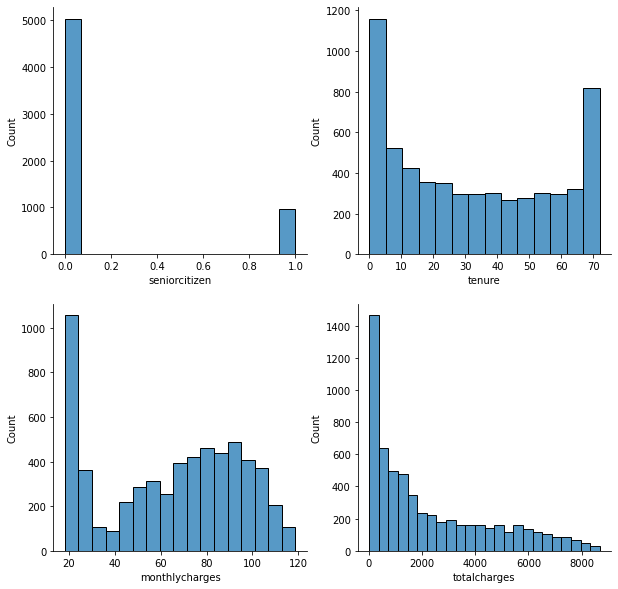

In [20]:
figure, axis = plt.subplots(2, 2, figsize=(10, 10))
fila = -1
columna = -1
for k in df.describe().columns:
    columna = columna + 1
    if columna == 2:
        columna = 0
    if columna == 0:
        fila = fila + 1
    if fila == 2:
        fila = 0
    sns.histplot(df[k], ax=axis[fila,columna])
sns.despine(figure)

La variable `seniorcitizen` es binaria, no continua. Para las otras se revisa la presencia de valores atípicos:

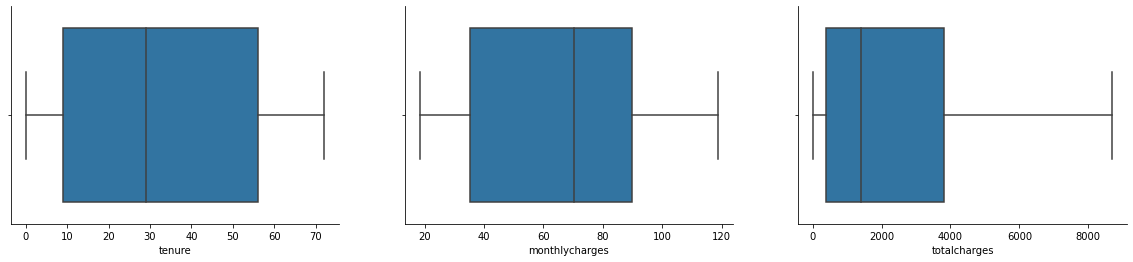

In [26]:
figure, axis = plt.subplots(1, 3, figsize=(20, 4))
indice = -1
for k in ['tenure','monthlycharges','totalcharges']:
    indice = indice + 1
    sns.boxplot(df[k], ax=axis[indice])
sns.despine(figure)

No existen valores extremos. Se revisan también las variables categóricas:

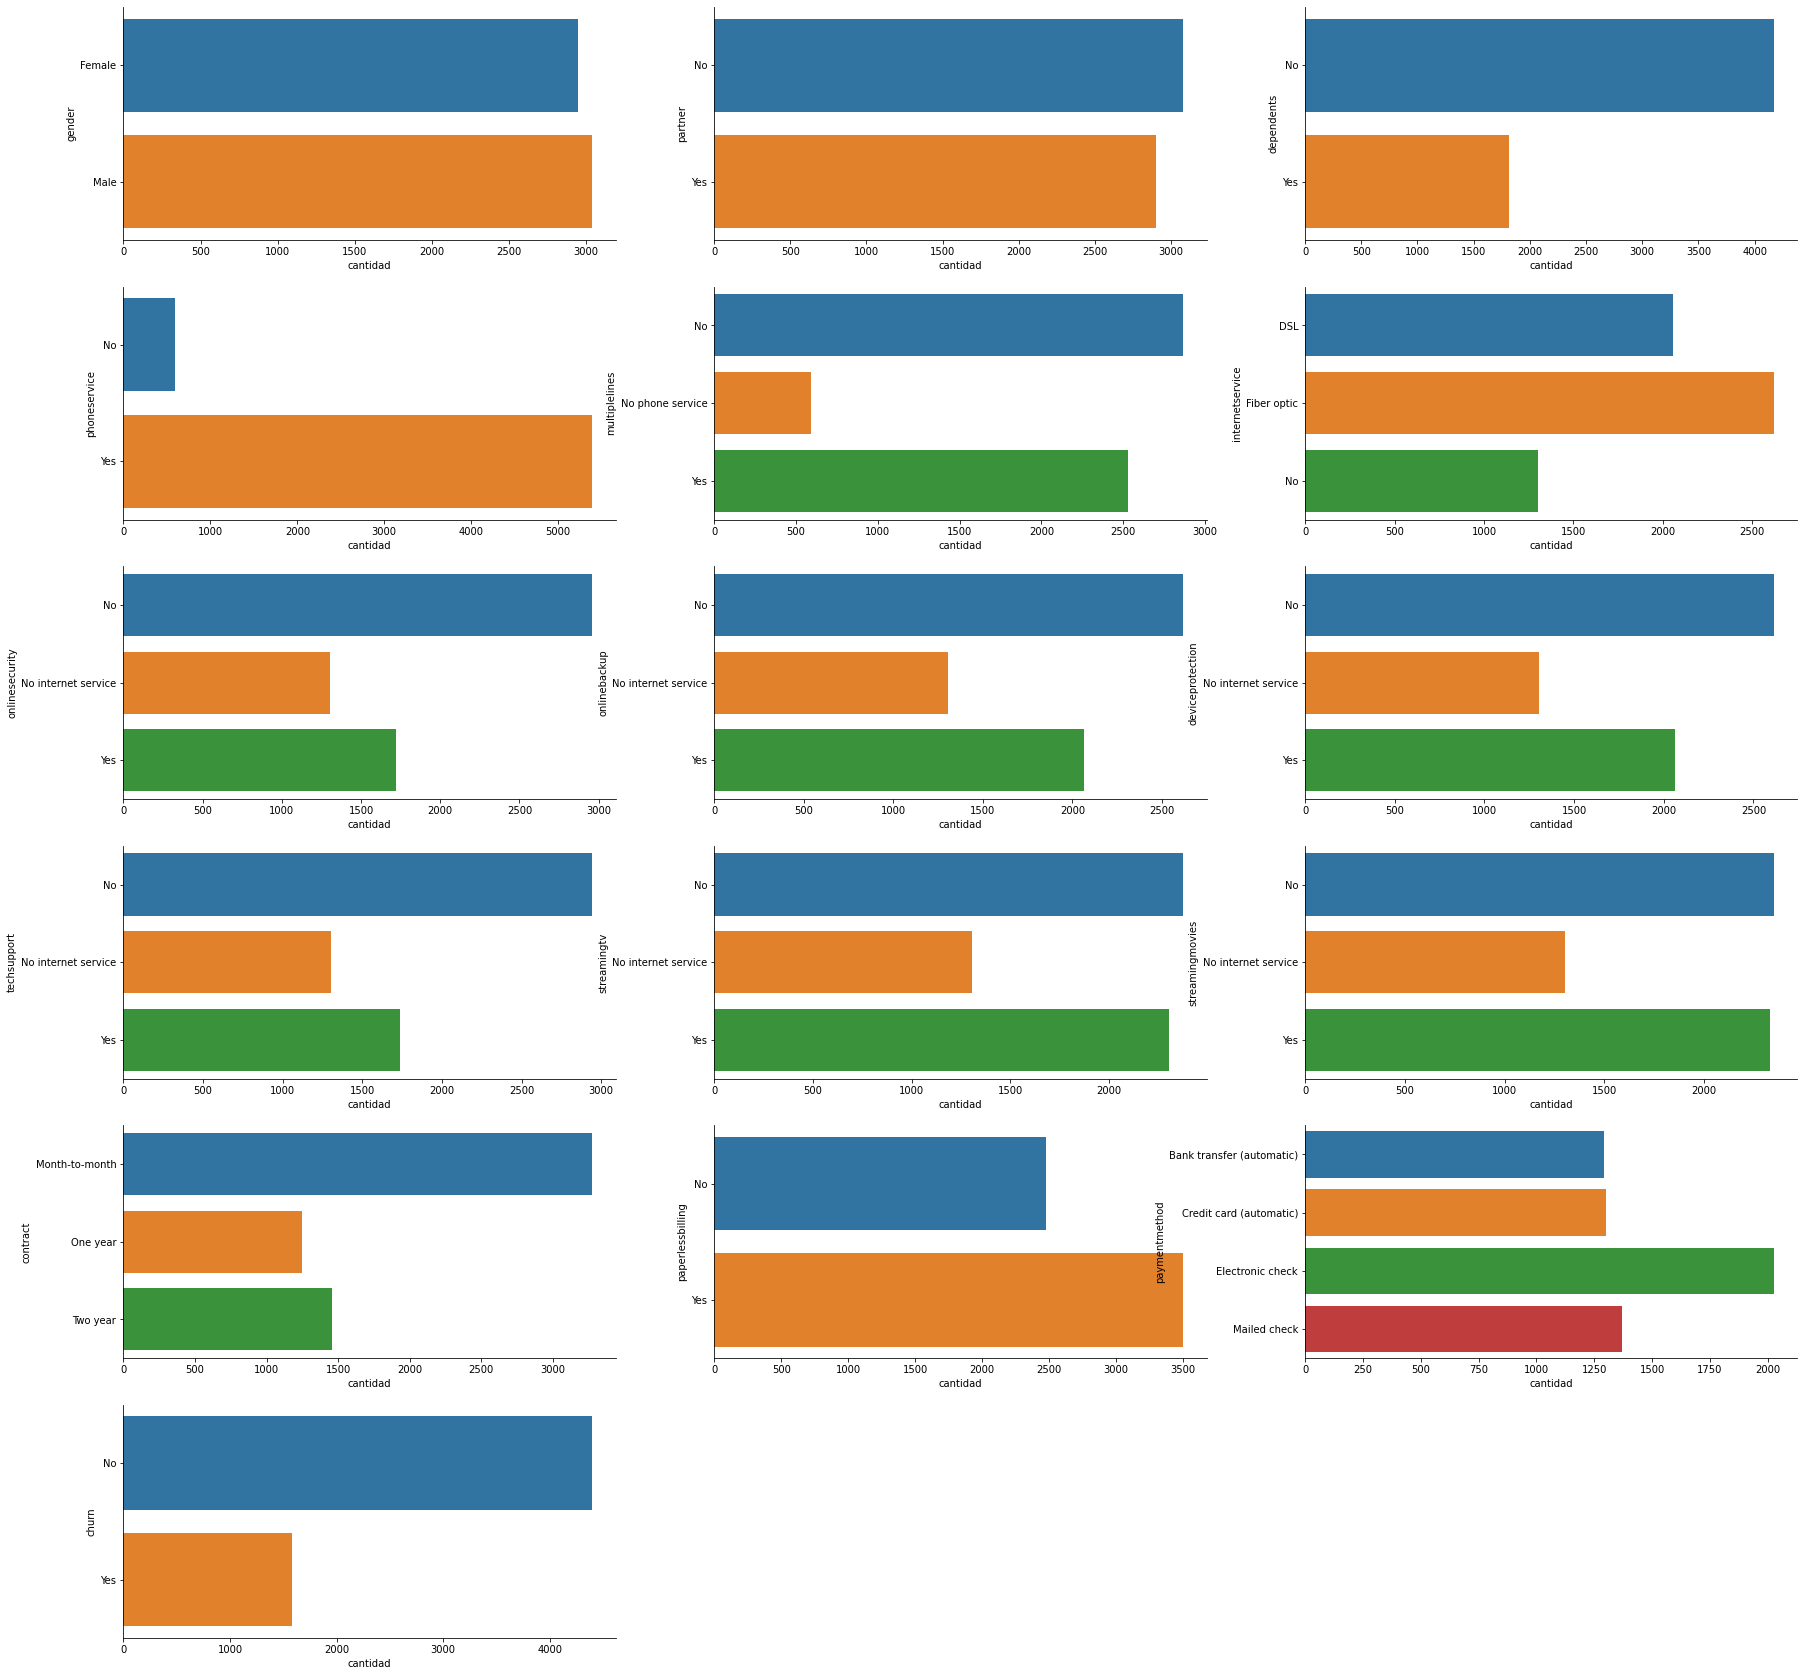

In [27]:
figure, axis = plt.subplots(6, 3, figsize=(30, 30))
fila = -1
columna = -1
for k in df.select_dtypes(include=['object']).columns:
    columna = columna + 1
    if columna == 3:
        columna = 0
    if columna == 0:
        fila = fila + 1
    if fila == 6:
        fila = 0
    cuadro = df[[k]].groupby(k)[k] \
                    .count() \
                    .reset_index(name='cantidad')
    sns.barplot(data = cuadro, y = k, x = 'cantidad', ax=axis[fila,columna])
figure.delaxes(axis[5,1])
figure.delaxes(axis[5,2])
sns.despine(figure)

En este caso no parece haber ningún problema, por lo que pueden usarse todas las variables. Solo se hace la transformación a variable numéricas de acuerdo a las necesidades de los algoritmos:

In [ ]:
# convierte variable objetivo a numérica
df['churn'] = np.where(df['churn'] == 'Yes', 1, 0)
# aplicación de one hot encoder
for k in df.select_dtypes(include=['object']).columns:
    onehotencoder = OneHotEncoder()
    var = onehotencoder.fit_transform(df[[k]])
    df[onehotencoder.categories_[0]] = var.toarray()
    del df[k]
# muestra algunos registros
df.sample(5)

En resumen, se aplicaron los siguientes tratamientos:

- Corrección de variable `totalcharges`.
- Eliminación de duplicados.
- Conversión de variable objetivo a variable binaria.
- Aplicación de one hot encoder

En el Pipeline, lo ideal será incluir estas transformaciones para poder encapsular el proceso de limpieza de datos.

## 2) Construcción de Pipelines

In [30]:
# regresión logística
pipeline1 = Pipeline([
    ('poly', 'passthrough'),
    ('normalizer', StandardScaler()),
    ('classifier',  LogisticRegression(multi_class='multinomial', solver='lbfgs'))
])
# máquina de vectores de soporte
pipeline2 = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())]
)